In [127]:
import cv2
from matplotlib import pyplot as plt
import numpy as np

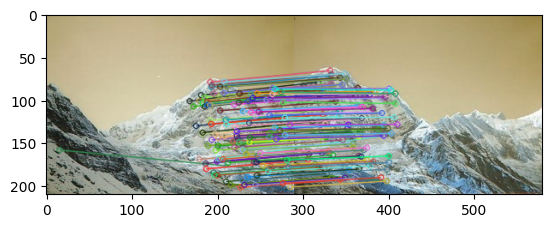

In [128]:
#________________point 1___________________
# Load images
img1 = cv2.imread('image 4-1.jpeg', cv2.COLOR_BGR2GRAY)
img2 = cv2.imread('image 4-2.jpeg', cv2.COLOR_BGR2GRAY)

# Initiate SIFT (Scale-Invariant Feature Transform) detector
# used for detecting and describing local features in images.
sift = cv2.SIFT_create()

# Find keypoints and descriptors
# Keypoints: Identifiable points in the image.
# Descriptors: describes the local image content around each keypoint.
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

# Create BFMatcher (Brute-Force Matcher) object
# compares feature descriptors between two images and computes the Euclidean distance between descriptors and finds the best matches.
bf = cv2.BFMatcher()

# Match descriptors
# computes the k-nearest neighbors for each descriptor in des1 with respect to des2.
# parameter k=2 --> the top 2 nearest neighbors for each descriptor.
# matches list --> contains pairs of descriptors from both images.
matches = bf.knnMatch(des1, des2, k=2)

# Apply ratio test
good_matches = []
#  filtering out incorrect matches
for m, n in matches:
    # if the distance of the first match (m) is smaller than the distance of the second match (n), it is considered a good match.
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

# Draw good matches
# flages = 2 --> means that the function doesn't draw the single keypoints that don't have corresponding matches.
img3 = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, flags=2)

plt.imshow(img3)
plt.show()


In [129]:
#________________point 2___________________
def sort():
    # Extract matched keypoints
    # now we have good_matches that contains the keypoints of each image 1 and 2 so we will split them 
    matched_kp1 = [kp1[m.queryIdx] for m in good_matches]
    matched_kp2 = [kp2[m.trainIdx] for m in good_matches]

    # Extract (x, y) coordinates from matched keypoints
    matched_points1 = [(kp.pt[0], kp.pt[1]) for kp in matched_kp1]
    matched_points2 = [(kp.pt[0], kp.pt[1]) for kp in matched_kp2]

    return matched_kp1 , matched_kp2

In [131]:
#__________Calculte the affine matrix for RANSAC function____________
def compute_affine_matrix2(src_pts, dst_pts):
  
  # affine --> any compination from the transformation
  # note: it is better to use the first point because it is the origin and also because the first point is less likely to be an outlier.
  
   # differences between the first and second points in the destination
   dx = dst_pts[1] - dst_pts[0]    # (vector ) 
   dy = dst_pts[2] - dst_pts[0]    # (vector from the first to the third point in the destination (dst_pts).)

   # sx --> is the scaling factor in the x-direction (in size)
   sx = np.linalg.norm(dx) / np.linalg.norm(src_pts[1] - src_pts[0])   # (a)
   # sy --> is the scaling factor in the y-direction
   sy = np.linalg.norm(dy) / np.linalg.norm(src_pts[2] - src_pts[0])   # (b)

   # Calculate the rotation angle
   # difference in angles between the vectors dy and the vector connecting the first and third points in the source (src_pts).
   # np.arctan2(dy[1], dy[0]) --> calculates the angle of the vector dy with respect to the x-axis (in radians).
   #     second angle         --> calculates the angle of the vector connecting the first and third points in the source (src_pts) with respect to the x-axis.
   theta = np.arctan2(dy[1], dy[0]) - np.arctan2(src_pts[2, 1] - src_pts[0, 1], src_pts[2, 0] - src_pts[0, 0])

   # Construct the linear transformation matrix   (Rotation)
   A = np.array([[sx * np.cos(theta), -sy *                 # (m1 = sx * cos(theta)    m2 = -sy * sin(theta))
                  np.sin(theta)],                           # (m3 = sx * sin(theta)    m4 = sy * cos(theta))
                [sx * np.sin(theta), sy * np.cos(theta)]])

   # Calculate the translation components
   t = dst_pts[0] - np.dot(A, src_pts[0])   # (tx , ty)   # vector (xi'=m1xi + m2yi + tx)    (yi'=m3xi + m4yi + ty) translation (from one place to another)

   # Construct the full affine transformation matrix
   # 3x3 matrix :The top-left 2x2 block contains the linear transformation (A).
   #             The last column contains the translation components (t).
   #             The last row is [0, 0, 1] (to make it square 3x3)
   affine_matrix = np.vstack((np.hstack((A, t.reshape(-1, 1))), np.array([0, 0, 1])))

   # print("Affine Transformation Matrix:")
   # print(affine_matrix)

   return affine_matrix

In [132]:
#________________point 3___________________
def RANSAC(matched_kp1 , matched_kp2):

    # 1) RANSAC parameters
    # we iterate to choose T with the largest inliers. 
    num_iterations = 1000
    # threshold value determines whether a point is considered an inlier or an outlie
    inlier_threshold = 5.0

    best_inliers = 0
    best_affine_matrix = None

    for _ in range(num_iterations):
        # Randomly select 3 matched keypoints
        sample_indices = np.random.choice(len(matched_kp1), 3, replace=False)
        src_pts = np.float32([matched_kp1[i].pt for i in sample_indices])
        dst_pts = np.float32([matched_kp2[i].pt for i in sample_indices])

        # Compute affine transformation
        # affine_matrix, _ = cv2.estimateAffinePartial2D(src_pts, dst_pts)

        affine_matrix = compute_affine_matrix2(src_pts, dst_pts) # (T)

        # # Evaluate inliers
        # transformed_pts = cv2.transform(np.array([src_pts]), affine_matrix)[0]
        # distances = np.linalg.norm(transformed_pts - dst_pts, axis=1)

        # Convert transformed points to non-homogeneous coordinates
        # homogeneous --> A point in 2D homogeneous coordinates is represented as (x, y, w).
        # non-homogeneous --> each point is represented by a pair of real numbers (x, y).
        transformed_pts_homogeneous = np.dot(affine_matrix, np.vstack((src_pts.T, np.ones(src_pts.shape[0]))))
        # extract the first two rows (x and y coordinates) from transformed_pts_homogeneous.
        # then we divide it by the third row (w coordinates) to obtain the non-homogeneous transformed points (transformed_pts).
        transformed_pts = transformed_pts_homogeneous[:2, :] / transformed_pts_homogeneous[2, :]
        # Calculate the distances between the transformed points and the destination points (dst_pts)
        # T --> means transpose of the matrix (swaps the x-coordinates with the y-coordinates).
        # axis = 1 --> means that the norm is performed along the rows (across the columns) of the matrix.
        distances = np.linalg.norm(transformed_pts.T - dst_pts, axis=1)

        # Count the number of inliers
        inliers = np.sum(distances < inlier_threshold)

        # Update best transformation
        if inliers > best_inliers:
            best_inliers = inliers
            best_affine_matrix = affine_matrix

    # Without suppress=True: 1.23e-05
    #With suppress=True: 0.0000123
    np.set_printoptions(suppress = True)
    # additional_row = np.array([0, 0, 1])

    # new_matrix = np.vstack((best_affine_matrix, additional_row))

    print(best_affine_matrix)
    return best_affine_matrix

In [135]:
#__________Calculate the RANSAC function using the projectve________
def RANSAC2(matched_kp1 , matched_kp2):
    # RANSAC parameters
    num_iterations = 1000
    inlier_threshold = 5.0  # Adjust this based on your data

    best_inliers = 0
    best_homography_matrix = None

    for _ in range(num_iterations):
        # Randomly select 4 matched keypoints for projective transformation
        sample_indices = np.random.choice(len(matched_kp1), 4, replace=False)
        src_pts = np.float32([matched_kp1[i].pt for i in sample_indices])
        dst_pts = np.float32([matched_kp2[i].pt for i in sample_indices])

        # Compute projective transformation (homography matrix)
        # maps points from one image to corresponding points in another image.
        homography_matrix, _ = cv2.findHomography(src_pts, dst_pts)

        # Evaluate inliers using perspective transformation
        # transform a set of points using a given homography matrix (projective transformation matrix).
        # transforms the points from the source coordinate system to the destination coordinate system.
        transformed_pts = cv2.perspectiveTransform(np.array([src_pts]), homography_matrix)[0]
        distances = np.linalg.norm(transformed_pts - dst_pts, axis=1)
        inliers = np.sum(distances < inlier_threshold)

        # Update best transformation if needed
        if inliers > best_inliers:
            best_inliers = inliers
            best_homography_matrix = homography_matrix

    return best_homography_matrix

In [157]:
#________________point 4___________________
def applyMAtrix(new_matrix):   #  apply an affine transformation matrix (new_matrix) to an input image (img1).

    # Get the dimensions of the second image (img2) to use it to create the output canvas.
    height, width = img2.shape[:2]
    # print(img1.shape)
    # print(height)
    # print(width)
    
    # Create an output canvas (white background)
    # we make first white canvas which all the pixels sets to 255 and have the same dimentions of image2.
    output_canvas = np.ones((height, width, 3), dtype=np.uint8) * 255

    # Inverse of the affine matrix (to map from output to input coordinates)
    inv_affine_matrix = np.linalg.inv(new_matrix)

    # Iterate through each pixel in the output canvas
    for y_out in range(height):
        for x_out in range(width):
            # Transform the (x, y) coordinates from output to input
            transformed_coords = np.dot(inv_affine_matrix, [x_out, y_out, 1])
            x_in, y_in = int(transformed_coords[0]), int(transformed_coords[1])

            # Check if the transformed coordinates are within the bounds of img1
            if 0 <= x_in < img1.shape[1] and 0 <= y_in < img1.shape[0]:
                # Assign the pixel value from img1 to the output canvas
                output_canvas[y_out, x_out] = img1[y_in, x_in]

    # # Overlay the transformed image onto the output canvas
    # output_canvas = cv2.addWeighted(output_canvas, 0.5, img2, 0.5, 0)

    return output_canvas

In [ ]:
def applyMatrix2(new_matrix):
    # Get the dimensions of the second image (img2)
    height, width = img2.shape[:2]

    # Create an output canvas (white background)
    output_canvas = np.ones((height, width, 3), dtype=np.uint8) * 255

    # Inverse of the affine matrix (to map from output to input coordinates)
    inv_affine_matrix = np.linalg.inv(new_matrix)

    # Iterate through each pixel in the output canvas
    for y_out in range(height):
        for x_out in range(width):
            # Transform the (x, y) coordinates from output to input
            transformed_coords = np.dot(inv_affine_matrix, [x_out, y_out, 1])
            x_in, y_in = int(transformed_coords[0]), int(transformed_coords[1])

            # Check if the transformed coordinates are within the bounds of img1
            if 0 <= x_in < img1.shape[1] and 0 <= y_in < img1.shape[0]:
                # Assign the pixel value from img1 to the output canvas
                output_canvas[y_out, x_out] = img1[y_in, x_in]

    return output_canvas


C:\Users\nerme\AppData\Local\Temp\ipykernel_4324\146260044.py:6: RuntimeWarning: invalid value encountered in scalar divide
  sx = np.linalg.norm(dx) / np.linalg.norm(src_pts[1] - src_pts[0])


[[   0.96809733   -0.13627958 -137.41040039]
 [   0.13813232    0.95511246  -34.31471252]
 [   0.            0.            1.        ]]
the result using the affine transformation: 


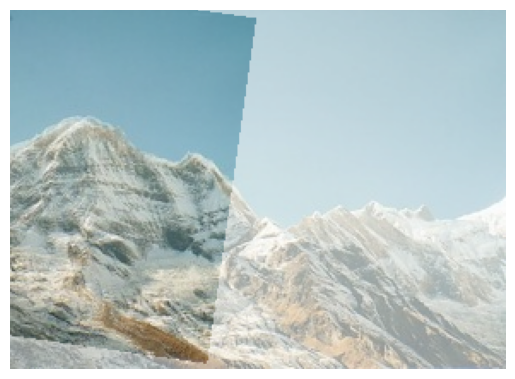

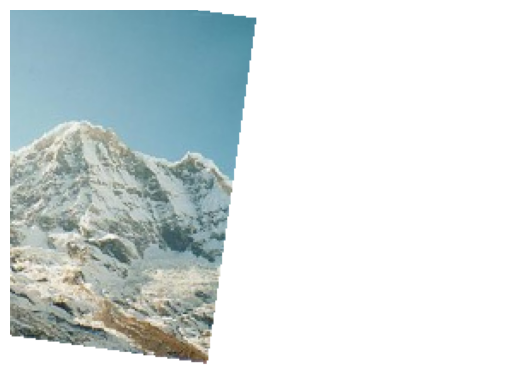

the result using the projective transformation: 


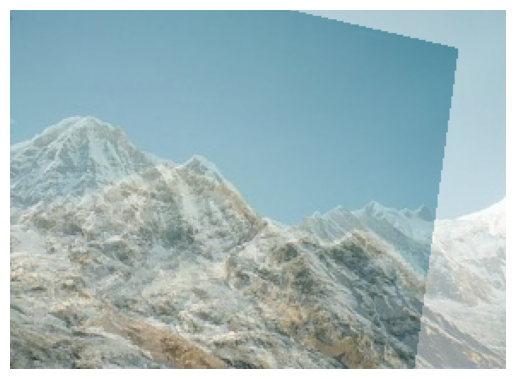

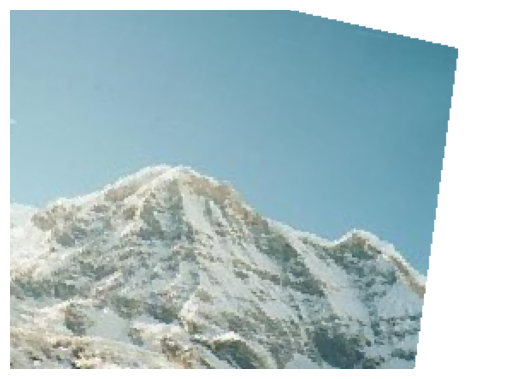

In [160]:
#________ display the alignment image (panorama) __________
matched_points1 , matched_points2 = sort()

T = RANSAC(matched_points1, matched_points2)
T2 = RANSAC2(matched_points1, matched_points2)

aligned_image1 = applyMAtrix(T)
aligned_image1_2 = applyMAtrix(T2)

# Overlay the transformed image onto the output canvas
# img2_resized = cv2.resize(img2, (aligned_image1.shape[1], aligned_image1.shape[0]))
panorama = cv2.addWeighted(aligned_image1, 0.5, img2, 0.5, 0)
panorama2 = cv2.addWeighted(aligned_image1_2, 0.5, img2, 0.5, 0)

print("the result using the affine transformation: ")
plt.imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# Display the result
plt.imshow(cv2.cvtColor(aligned_image1, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# Display the result
print("the result using the projective transformation: ")
plt.imshow(cv2.cvtColor(panorama2, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# Display the result
plt.imshow(cv2.cvtColor(aligned_image1_2, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()